In [46]:
from astropy import units as u                                                                                                             
from astropy.nddata import CCDData                                                                                                         
from astropy.io import fits
from astropy.stats import sigma_clip
import ccdproc
from ccdproc import Combiner        
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import glob
%matplotlib inline
plt.style.use("dark_background")
dr = "/home/fischwagen/prg/astronomy/BDF/"
plt.rcParams['figure.figsize'] = [14, 7]

# Move most used functions to different file, because who tf knows what's going on here

In [100]:
def save_fits(data, file_name, overwrite_flag=True):
    hdu = fits.PrimaryHDU(data=data)
    hudl = fits.HDUList([hdu])
    hudl.writeto(file_name, overwrite=overwrite_flag)

In [162]:
def trim_fits(arr):
    shape = arr.shape
    ccd = CCDData(arr, unit=u.adu)
    ccd = ccdproc.trim_image(ccd[:shape[0]-17, :])
    ccd = ccdproc.trim_image(ccd[:, 12:])
    return ccd

In [3]:
def trim_fits_big(arr):
    shape = arr.shape
    ccd = CCDData(arr, unit=u.adu)
    ccd = ccdproc.trim_image(ccd[:shape[0]-34, :])
    ccd = ccdproc.trim_image(ccd[:, 24:])
    return ccd

In [4]:
def show_fits(file_path):
    d = fits.getdata(file_path)
    plt.imshow(d, cmap="gray")
    plt.colorbar()

In [13]:
def num_tests(python_file, aij_file):
    py = fits.getdata(python_file)
    aij = fits.getdata(aij_file)
    aij = trim_fits_big(aij)
    print("std py: ", np.std(py))
    print("std aij: ", np.std(aij))
    print("median py: ", np.median(py))
    print("median aij: ", np.median(aij))
    #return py - aij

In [6]:
def bin_image(arr, block_size):
    return ccdproc.block_average(arr, block_size=block_size)

In [8]:
def create_bias(file_path: str, out_name: str, overwrite=True) -> None:
    header_red = False
    data = []
    files = glob.glob(file_path)
    for file in files:
        if header_red == False:
            header = fits.getheader(file)
            header_red == True
        ccd = CCDData(fits.getdata(file), unit=u.adu)
        data.append(ccd)
    combiner = Combiner(data)
    combined_median = combiner.median_combine()
    #combined_median = ccdproc.subtract_overscan(combined_median, overscan=combined_median[12:, :], overscan_axis=None)
    #save_fits(combined_median, out_name, overwrite)
    fits.writeto(out_name, combined_median, header, overwrite=overwrite)

In [9]:
create_bias(f"{dr}BIAS*.FIT", "mbias.fit")

In [10]:
def create_dark(file_path, out_name, overwrite=True, bias_path=None):
    header_red = False
    if bias_path is not None:
        bias = CCDData(fits.getdata(bias_path), unit=u.adu)
        
    data = []
    files = glob.glob(file_path)
    for file in files:
        if header_red == False:
            header = fits.getheader(file)
        ccd = CCDData(fits.getdata(file), unit=u.adu)
        data.append(ccd)
    
    combiner = Combiner(data)
    combined_median = combiner.median_combine()
    #combined_median = ccdproc.subtract_overscan(combined_median, overscan=combined_median[12:, :], overscan_axis=None)
    #save_fits(combined_median, out_name, overwrite)
    
    if bias_path is not None:
        result = combined_median.subtract(bias)
        fits.writeto(out_name, result, header, overwrite=overwrite)
        #save_fits(result, out_name, overwrite)
    else:
        fits.writeto(out_name, combined_median, header, overwrite=overwrite)
        #save_fits(combined_median, out_name, overwrite)

In [11]:
create_dark(f"{dr}DARK*.FIT", "mdark.fit", "mbias.fit")

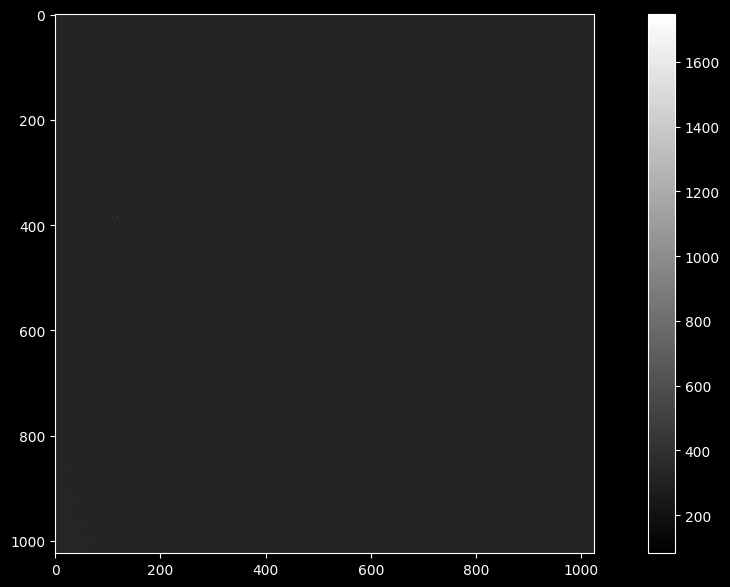

In [12]:
show_fits("mdark.fit")

In [13]:
def create_flat(file_path, out_name, overwrite=True, bias_path=None, dark_path=None):
    header_red = False
    bd_remove = False
    if bias_path is not None and dark_path is not None:
        bd_remove = True
        bias_data = fits.getdata(bias_path) 
        dark_data = fits.getdata(dark_path)
        bias_max = np.max(bias_data)
        dark_max = np.max(dark_data)
        dark = CCDData(bias_data, unit=u.adu)
        bias = CCDData(dark_data, unit=u.adu)
    elif bias_path is not None or dark_path is not None:
        print("Error: provide bias and dark images or none")
        exit(1)
        
    data = []
    files = glob.glob(file_path)
    for file in files:
        fits_file = fits.getdata(file)
        if header_red == False:
            header = fits.getheader(file, 0)
            header_red = True
        flat_av = np.mean(fits_file)
        ccd = CCDData(fits_file, unit=u.adu)
        if bd_remove == True:
            ccd = ccd.subtract(bias)
            ccd = ccd.subtract(dark)
        ccd = ccd.divide(flat_av)
        data.append(ccd)
    
    combiner = Combiner(data)
    combined_median = combiner.median_combine()
    #combined_median = ccdproc.subtract_overscan(combined_median, overscan=combined_median[12:, :], overscan_axis=None)
    #save_fits(combined_median, out_name, overwrite)
    #hdulist = combined_median.to_hdu()
    #combined_median.write(out_name, overwrite=True)
    fits.writeto(out_name, combined_median, header, overwrite=overwrite)

In [14]:
create_flat(f"/home/fischwagen/prg/astronomy/flat/flat/*", "/home/fischwagen/prg/astronomy/flat/flat/mflat.fit")

TypeError: CCDData objects are not the same size.

In [ ]:
show_fits("mflat.fit")

In [ ]:
def remove_cold_pixels(arr):
    """
    Function removes pixels with negative values, assuming trimmed image.
    """
    #m = np.array([[0, 0, 0],
    #              [0, 1, 0],
    #              [0, 0, 0]])
    shape = arr.shape
    neg_vals = np.where(arr < 0)
    for i, j in zip(neg_vals[0], neg_vals[1]):
        med = arr[i-1:i+2, j-1:j+2]
        #mask_med = ma.array(med, mask=m)
        #median = np.median(mask_med)
        median = np.median(med)
        arr[i, j] = median
    return arr

In [24]:
def remove_hot_pix(arr, hot_pix_file):
    x, y = [], []
    with open(hot_pix_file, "r") as f:
        lines = f.readlines()
        for line in lines:
            text = line.split()
            x.append(int(text[0]))
            y.append(int(text[1]))

    for i, j in zip(x, y):
        med = np.median(arr[i-1:i+2, j-1:j+2])
        arr[i, j] = med
    return arr

In [ ]:
t = fits.getdata("/home/fischwagen/prg/astronomy/test_red/r1.fit")
t =remove_cold_pixels(t)
plt.imshow(t, cmap="gray", vmin=10000, vmax=65535)
plt.colorbar()

In [ ]:
def create_reduced_image(image, bias, dark, flat, out_name):
    """
    Function does image reduction and trimming.
    image, bias, dark, flat - paths to images
    """
    header = fits.getheader(image, 0)
    im = CCDData.read(image, unit=u.adu)
    bs = CCDData.read(bias, unit=u.adu)
    dk = CCDData.read(dark, unit=u.adu)
    ft = CCDData.read(flat, unit=u.adu)
    
    im = trim_fits(im)
    bs = trim_fits(bs)
    dk = trim_fits(dk)
    ft = trim_fits(ft)
    #dk.header['exposure'] = 180.0
    header["HISTORY"] = "trimmed image"
    bias_subtracted = ccdproc.subtract_bias(im, bs)
    header["HISTORY"] = "bias corrected"
    dark_subtracted = ccdproc.subtract_dark(bias_subtracted, dk, exposure_time='EXPOSURE', exposure_unit=u.second, scale=False)
    flat_corr = ccdproc.flat_correct(dark_subtracted, ft, min_value=0.001)
    fits.writeto(out_name, flat_corr, header, overwrite=True)
    reduced = fits.getdata(out_name)
    reduced = np.clip(reduced, 0, 65535, dtype=np.uint16)
    fits.writeto(out_name, flat_corr, header, overwrite=True)
    #save_fits(flat_corr, out_name, True)
    #return flat_corr

In [ ]:
def create_reduced_image_big(image, bias, dark, flat, out_name, bin_size=1):
    """
    Function does image reduction and trimming.
    image, bias, dark, flat - paths to images
    """
    h_info = "HISTORY"
    #header = fits.getheader(image, 0)
    im = CCDData.read(image, unit=u.adu)
    bs = CCDData.read(bias, unit=u.adu)
    dk = CCDData.read(dark, unit=u.adu)
    ft = CCDData.read(flat, unit=u.adu)
    
    im = trim_fits_big(im)
    bs = trim_fits_big(bs)
    dk = trim_fits_big(dk)
    ft = trim_fits_big(ft)
    bias_subtracted = ccdproc.subtract_bias(im, bs)
    dark_subtracted = ccdproc.subtract_dark(bias_subtracted, dk, exposure_time='EXPOSURE', exposure_unit=u.second, scale=False)
    flat_corr = ccdproc.flat_correct(dark_subtracted, ft, min_value=0.001)
    header = flat_corr.header
    fits.writeto(out_name, flat_corr, header, overwrite=True)
    reduced = fits.getdata(out_name)
    
    reduced = remove_hot_pix(reduced, "/home/fischwagen/prg/astronomy/hot_bin1_gain0.dat")
    reduced = np.clip(reduced, 0, 65535)
    if bin_size > 1:
        reduced = bin_image(reduced, bin_size)
        header["XBINNING"] = bin_size
        header["YBINNING"] = bin_size
    reduced = reduced.astype(np.uint16)
    fits.writeto(out_name, reduced, header, overwrite=True)

In [ ]:
#create_bias("/home/fischwagen/prg/astronomy/bias/*mode1*", "bias2.fit", True)
#create_dark("/home/fischwagen/prg/astronomy/dark/*mode1*", "dark2.fit", True, "bias2.fit")
#create_flat("/home/fischwagen/prg/astronomy/flat/*flat_B*", "flat2.fit", True, "bias2.fit", "dark2.fit")
create_flat("/home/fischwagen/prg/astronomy/flat/flat/2024-04-18_06-46-19__L_6.59s_1x1_0_0000_rawbkp.fits", 
            "/home/fischwagen/prg/astronomy/flat/flat/mflatTest.fit", True, 
            "/home/fischwagen/prg/astronomy/bias/mbias_qhy268_mode1_gain0_offset10_usb50_temp-10_bin1.fits",
            "/home/fischwagen/prg/astronomy/dark/mdark120_qhy268_mode1_gain0_offset10_usb50_temp-10.fits")

In [ ]:
path = "/home/fischwagen/prg/astronomy/"
#reduced = create_reduced_image("/home/fischwagen/astronomy/ngc2068/PAN4_90597_HOYS-UZ_00_NGC2068_00_B_00_2023_11_06_07_31_43.fits.gz",
#                     f"{path}bias/bias_mode1_usb10_gain0_offset10_temp-10_bin2_05112023.fit",
#                     f"{path}dark/dark_mode1_usb10_gain0_offset10_temp-10_bin2_05112023.fit",
#                     f"{path}flat/master_flat_B.fits")
create_reduced_image_big("/home/fischwagen/prg/astronomy/test/2024-04-17_22-54-55_WASP-185b_R_60.00s_1x1_0_0001.fits",
                    f"{path}bias/mbias_qhy268_mode1_gain0_offset10_usb50_temp-10_bin1.fits",
                    f"{path}dark/mdark120_qhy268_mode1_gain0_offset10_usb50_temp-10.fits",
                    f"{path}flat/flat/mflatTest.fit", "/home/fischwagen/prg/astronomy/test_red/finalFbinned.fit", bin_size=2)

## Testy

In [ ]:
for i in range(1, 9):
    im = fits.getdata(f"/home/fischwagen/prg/astronomy/test_red/r{i}.fit")
    im = remove_cold_pixels(im)
    save_fits(im, f"RC{i}.fit", True)

In [ ]:
py = fits.getdata("test.fit")
aij = fits.getdata("/home/fischwagen/prg/astronomy/test/pipelineout/2024-04-17_22-54-55_WASP-185 b_R_60.00s_1x1_0_0001_out.fits")
aij = trim_fits_big(aij)

In [ ]:
print(np.std(py))
print(np.std(aij))
print(np.median(py ))
print(np.median(aij))
#res = py - aij

In [ ]:
img = CCDData.read("/home/fischwagen/astronomy/ngc2068/PAN4_90597_HOYS-UZ_00_NGC2068_00_B_00_2023_11_06_07_31_43.fits.gz", unit=u.adu)
bs = CCDData.read(f"{path}bias/bias_mode1_usb10_gain0_offset10_temp-10_bin2_05112023.fit", unit=u.adu)
dk = CCDData.read(f"{path}dark/dark_mode1_usb10_gain0_offset10_temp-10_bin2_05112023.fit", unit=u.adu)
img = trim_fits(img)
bs = trim_fits(bs)
bias_subtracted = ccdproc.subtract_bias(img, bs)
print(bs.shape)
dk = trim_fits(dk)
dark_subtracted = ccdproc.subtract_dark(bias_subtracted, dk, exposure_time='EXPOSURE', exposure_unit=u.second, scale=True)
save_fits(dark_subtracted, "abc.fit")

In [ ]:
print(np.std(dark_subtracted))
b = fits.getdata(f"{path}ngc2068/dark/PAN4_90597_HOYS-UZ_00_NGC2068_00_B_00_2023_11_06_07_31_43_out.fits")
b = trim_fits(b)
print(np.std(b))

In [ ]:
r = fits.getdata("./RC1.fit")
r = trim_fits_big(r)
r = np.array(r, dtype=np.uint16)
save_fits(r, "test.fit")

In [ ]:
res =num_tests("/home/fischwagen/prg/astronomy/test_red/final.fit", "/home/fischwagen/prg/astronomy/test/pipelineout/2024-04-17_22-54-55_WASP-185 b_R_60.00s_1x1_0_0001_out.fits")

In [ ]:
plt.imshow(res, cmap="gray")
plt.colorbar()

In [ ]:
test = fits.getdata("/home/fischwagen/prg/astronomy/test_red/finalF.fit")
#use block_reduce
#def bin_image(arr):
#    shape = arr.shape
#    new = np.zeros((shape[0]//2, shape[1]//2))
#    for i in range(shape[0]):
#        for j in range(shape[1]):
#            if i % 2 == 0 or j % 2 == 0:
#                av = np.mean(arr[i:i+2, j:j+2]) 
#                new[i//2, j//2] = av
#    return new

def bin_image(arr, val):
    return ccdproc.block_average(arr, val)

In [ ]:
binned = bin_image(test, 2)

In [ ]:
plt.imshow(binned, cmap="gray", vmin = 0, vmax=1000)
save_fits(binned, "binned.fit")

In [81]:
hot_rm = fits.getdata("/home/fischwagen/prg/astronomy/test/2024-04-17_22-54-55_WASP-185b_R_60.00s_1x1_0_0001.fits")
print(hot_rm.shape)
#hot_rm = remove_hot_pix(hot_rm, "/home/fischwagen/prg/astronomy/hot_bin1_gain0.dat")
#save_fits(hot_rm,

(4210, 6280)


In [157]:
def rm_overscan(arr):
    masked_ov = sigma_clip(arr[:, :12], sigma=2, masked=True)
    #`print(np.sum(masked_ov))
    #`print(arr.shape)
    #`print(masked_ov.mask.shape)
    zero = np.zeros_like(arr, dtype=np.bool)
    #print(zero.shape)
    zero[:, :12] = masked_ov.mask
    zero = zero.astype(np.uint)
    #print(np.sum(zero.astype(np.uint)))
    
    
    #hdu = fits.PrimaryHDU(data=zero.astype(np.uint16))
    hdu = fits.PrimaryHDU(data=masked_ov.astype(np.uint))
    hudl = fits.HDUList([hdu])
    hudl.writeto("mask.fit", overwrite=True)
    ccd = CCDData(arr, unit=u.adu, mask=zero)
    return ccdproc.subtract_overscan(ccd, overscan=ccd[:, :12], overscan_axis=1, median=True)

#rm_ovsc = rm_overscan(hot_rm)

In [168]:
def reduce2(image, flat, hot_pix_map):
    im = fits.getdata(image)
    im = remove_hot_pix(im, hot_pix_map)
    im = bin_image(im, 2)
    im = rm_overscan(im)
    im = trim_fits(im)
    
    ft = fits.getdata(flat)
    ft = remove_hot_pix(ft, hot_pix_map)
    ft = bin_image(ft, 2)
    ft_av = np.mean(ft)
    ft = rm_overscan(ft)
    ft = trim_fits(ft)
    ft = ft.divide(ft_av)

    reduced = im.divide(ft)
    reduced = np.asarray(reduced, dtype=np.uint16)
    return reduced
    

In [169]:
reduced = reduce2("../astronomy/test/2024-04-17_22-54-55_WASP-185b_R_60.00s_1x1_0_0001.fits",
        "../astronomy/flat/flat/2024-04-18_06-46-19__L_6.59s_1x1_0_0000_rawbkp.fits",
        "../astronomy/hot_bin1_gain0.dat")
save_fits(reduced, "reduced2.fit", True)

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


In [45]:
rpy = fits.getdata("./reduced2.fit")
raij = fits.getdata("../astronomy/test/2024-04-17_22-54-55_WASP-185b_R_60.00s_1x1_0_0001.fits")
raij = bin_image(raij, 2)
save_fits(raij, "binned.fit", )

float64


In [36]:
print(np.std(rpy))
print(np.std(raij))
print(np.median(rpy))
print(np.median(raij))

106.51875652725552
72.8342908652039
49.38581862529128
204.0
